# Introduction

As data scientists we are constantly fighting the feature battle. For one, they are NEVER good enough. Then, if that is not enough, we either have too few or way too many features. Think about images, each pixel is a 'feature' - that means that high resolution images probably have way to much information (heh, well not really, but definitely too many for my personal computer). So we need a way, as is always the goal, to extract or find the best features from the dataset; we want the fewest number of features that contain the most and best information - to have our cake and eat it too.

Enter the idea of an embedding. A method to translate a high dimensional vector to a low(er) dimensional space. Embeddings do this by trying to place things that are similar (similarity can determined by the item's label, or maybe what it occurs near/with, however you want to define it), closer together in the lower dimensional space.

From the paragraph above, it seems like we are just describing dimensionality reduction, and in a sense, we are. However, this is more of a label dependent dimensionality reduction with the bonus of being very general. An embedding can learn thousands of labels at once, because they are looking for similarity among the data with attached labels. In addition, you can easily change your labels (adding, removing, altering), and the embedding can still provide a lot of value.

Finally, once data has been projected into the lower dimensional space they are just 'features' and can be easily shared across teams and used in other models. A huge bonus for cross data science team collaboration.

In this post I will do a few things. First, I will go into embeddings a little more, comparing them with familiar methods like PCA and other dimensionality techniques. In the following sections I will be creating models for the [Fahsion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. The first will be a simple model using only principal component analysis (PCA) and K nearest neighbors (KNN) and the second will use an embedding network with KNN. Along the way we will make some interesting plots and hopefully gain some insight into methods for classifying images.

# Embeddings

When reducing dimensions of data, we are trying to learn a coordinate space that is as informative as possible. Hearing this, my mind immediately goes to PCA, which can be thought of as an 'embedding' of sorts as it transforms possibly correlated values into linearly uncorrelated values and in the process allows you to reduce your dimensions by leaving out some (a specified amount) of the variance - a lossy embedding. This is a powerful tool, you are guaranteed that some percent of the variance of the dataset is kept, and ensures you don't have any collinear columns. If you work in industry, your first model will likely be a regression of some flavor giving major bonus points there.

So why bother with a more involved approach like an embedding when we have tools like PCA or Latent Semantic Analysis (LSA) (we'd likely use LSA for extremely sparse data as PCA does not work too well there)? For one, PCA can, in a sense, be 'tricked' into thinking something may be important or informative in your data when it might not be at all. For instance, let's assume you have a dataset containing a few columns with real structure, and a few columns that look like white noise. In this case PCA won't distinguish between the meaningful and the noise, resulting in a mixture of both. This is not ideal, and leads to one of the major advantages of a learned embedding - they can learn to ignore noise variance and only pay attention to variation that is actually useful for your learning task.

Now let's actually talk about embeddings a little. After a bit of research it seems like there are a few types of embeddings, some that map high dimensional sparse data to lower dimensional dense vectors and 'trained' embeddings that can do the same. The former, is generally what you see in the Keras API (`keras.layers.Embedding`) and maps an index (or sparse vector if one hot encoded) to a (mostly unique) dense vector of specified shape. I should note that these are 'trainable' but have some limitations - it can only map sparse vectors and can only be the first layer of the NN. Next are the 'trained' embeddings. One of the most popular in this space is [word2vec](https://www.tensorflow.org/tutorials/representation/word2vec). Which maps sparse vectors to meaningful lower dimensional vectors as it was trained to put 'similar' words near each other. So, there is something for words but what if we need to group images or some other type of one hot vector (maybe recommend products to a customer?).

In these cases, you will want to train your own embedding with a given objective in mind. We see this more and more with recommendation systems, where they want to learn a representation for an item based on how users interacted with it (sounds like a similar goal of collaborative filtering - yep - but with NNs). With a specific goal in mind (think loss function here) you can better learn lower dimensional representations of your data (important for the data science and performance of the system!). I should note that it is the training of these where it starts to get tricky, and this is where I hope this post will be of some help.

# Models

This post will be building classification models for the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset.

It has been shown that you can get really good performance (97% accuracy, [example](https://steven.codes/blog/ml/how-to-get-97-percent-on-MNIST-with-KNN/)) on the MNIST dataset using only PCA and KNN. The section `PCA + KNN` will contain a model that does just that on the Fashion MNIST data to set the baseline. Then in `Embedding + KNN` we will train an embedding to get features for the KNN and compare its prediction accuracy to the baseline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.utils import np_utils  # for turning the labels to OHE
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Lambda
from keras.layers import Dropout, GaussianNoise, GlobalMaxPooling2D
from keras.models import Model
from keras.metrics import categorical_accuracy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize": (12, 6),
        "font.size": 14,
    }
)

Using TensorFlow backend.


### Data

Fashion MNIST. Here we will do a few transformations that make it easier to work with. Including scaling and creating a one hot categorical for predictions.

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train_shape = x_train.shape
x_test_shape = x_test.shape

# these are the actual images (28, 28) in shape
#scaler = 255.0  # scaling MNIST with the standard scaler is usually problematic, this seems to work pretty well though.
#x_train_scaled = x_train / scaler
#x_test_scaled = x_test / scaler

# this is slightly sneaky since it disadvantages PCA slightly
variance_im = np.std(x_train, axis=0) + 0.1
x_train_scaled = x_train / variance_im.reshape((1, 28, 28))
x_test_scaled = x_test / variance_im.reshape((1, 28, 28))

# flattened images - each row is an image, each column is a pixel (or feature)
# 28 * 28 = 784
x_train_scaled_flat = x_train_scaled.reshape(x_train_shape[0], 784)
x_test_scaled_flat = x_test_scaled.reshape(x_test_shape[0], 784)

n_labels = 10
Y_train = np_utils.to_categorical(y_train, n_labels)
Y_test = np_utils.to_categorical(y_test, n_labels)

### PCA + KNN

Ok, so how do we make a model to predict a label for this data set? First we need to set up our features - in this case that is the images. To do this we need to make a data structure where each row represents an observation and each column represents a feauture. Seems easy enough, let's give it a go. 

First let's look at how much variance $n$ features from PCA will explain.

In [0]:
pca_investigation = PCA()
pca_investigation = pca_investigation.fit(x_train_scaled_flat)

Great. So it looks like just a few feautures from PCA captures a considerable amount of variance. Picking the number of dimensions we embed into can be somewhat arbitrary, but it seems like a lot of studies/examples reduce down to 32 (with pretty large starting states, like this image). With embeddings this gives quite a bit of information, while still being small enough to keep a system performant (something to consider in production data science) - for this reason, and the fact that 32 features captures 83% we will choose 32 feautres as our base.

32 features captures 76% of the variance


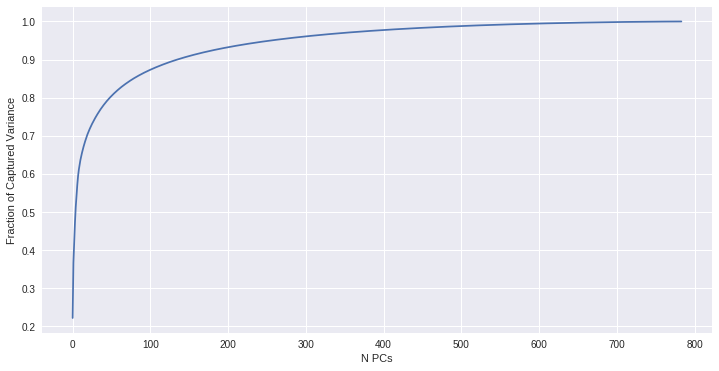

In [4]:
cum_var = np.cumsum(pca_investigation.explained_variance_ratio_)
fig = plt.figure('variance explanation')
ax = fig.add_subplot(111)
ax.plot(cum_var)
ax.set_xlabel('N PCs')
ax.set_ylabel('Fraction of Captured Variance')

n_components = 32
print(f'{n_components} features captures {cum_var[n_components] * 100:0.0f}% of the variance')

Let's build our model. The following cells will contain all the code necessary to create a 'simple' model for this data. Feel free to alter parameters and mess with it to get better/worse performance. Ill be wrapping these in functions to avoid cluttering up the name space, especially later with the NN. The models should be a simple enough to remove from the function if needed.

In [5]:
def pca_knn_model(x_train, y_train, x_test, y_test, n_neighbors=5):

  pca = PCA(n_components=n_components)
  train_pcs = pca.fit_transform(x_train)
  
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(train_pcs, y_train)
  
  test_pcs = pca.transform(x_test)
  
  preds = knn.predict(test_pcs)
  
  acc = accuracy_score(y_test, preds)
  
  print(f'Accuracy: {acc}')
  
  return pca, knn

simple_pca, simple_knn = pca_knn_model(x_train_scaled_flat, Y_train, x_test_scaled_flat, Y_test)

Accuracy: 0.8276


Our simple model with PCA and a KNN does pretty well.

For some more insight into our data, let's look at the images projected onto the the first 2 principal components. Let's plot the density of the PCs, showing where most of them lie. Then over top of that we will sample some of the labels of each PC and show where they fall.  Ideally they will be able to separate the labels very cleanly with no overlap - making it easy for our model to learn what label an image should get. Obviously, looking at the plot below we are not in an ideal world, but I'd argue that we can see some pretty good separation in labels from these features.

Again, feel free to mess with the PCs being plotted by changin `pc_x` and/or `pc_y`.


Text(0, 0.5, 'Data Project onto PC 2')

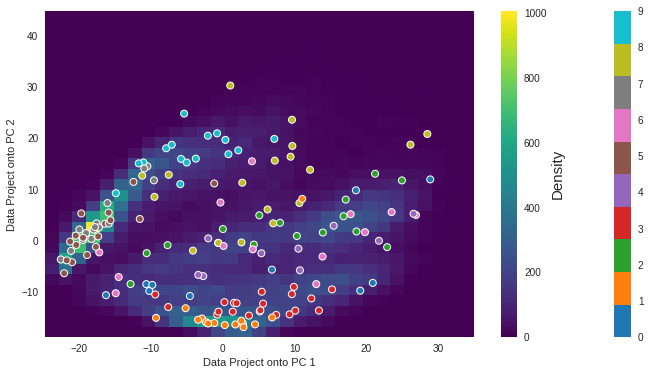

In [6]:
simple_pcs = simple_pca.transform(x_train_scaled_flat)

pc_x = 0
pc_y = 1

fig, ax = plt.subplots()
density_map = ax.hist2d(
    simple_pcs[:, pc_x],
    simple_pcs[:, pc_y],
    bins=31,
    cmap="viridis"
)
every_n = 400  # take every nth image and label to plot over the sensity map
scat = ax.scatter(
    simple_pcs[::every_n, pc_x],
    simple_pcs[::every_n, pc_y],
    c=y_train[::every_n],
    cmap="tab10",
    edgecolor="w",
    linewidths=1
)
plt.colorbar(scat).ax.set_label("Category")
plt.colorbar(density_map[3]).set_label("Density", fontsize=15)
ax.set_xlabel(f'Data Project onto PC {pc_x + 1}')
ax.set_ylabel(f'Data Project onto PC {pc_y + 1}')

Here is another look at the plot above. We can see that there are a large number of overlapping labels in PC space - there is no really clean separation.

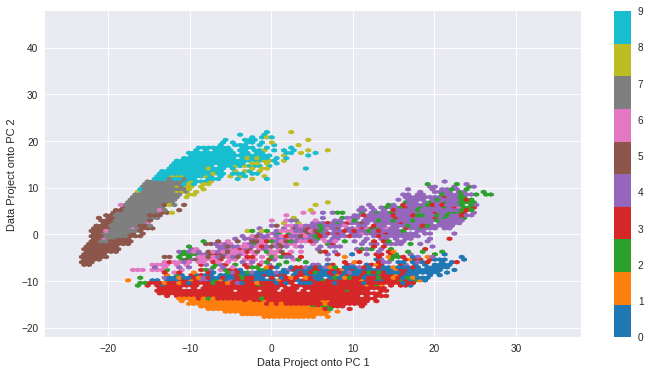

In [7]:
min_count = 10

fig = plt.figure('Principal components from images')
ax = fig.add_subplot(111)
hexb = ax.hexbin(
    simple_pcs[:, pc_x], 
    simple_pcs[:, pc_y], 
    mincnt=min_count, 
    C=y_train, 
    cmap='tab10',
    reduce_C_function=np.median
)
ax.set_xlabel(f'Data Project onto PC {pc_x + 1}')
ax.set_ylabel(f'Data Project onto PC {pc_y + 1}')
plt.colorbar(hexb)

## Embedding + KNN

Now the fun stuff. We want to train an embedding network for our images and then use the output of that to predict the labels. In reality, we did sort of learn an embedding in the section above, but this time the learned mapping will be non-linear and will get to take a look at the labels to inform it.

We mentioned before that PCA can be 'tricked' in some cases. It is common practice in data science to scale your data, especially when you are working with columns of fundamentally differing scales (and working with PCA). This is to ensure no one column dominates the rest as PCA listens to variance and not information. You probably noticed in the data loading section that there is scaled data - the data is scaled by the variance of that pixel across all images. I should note that is scaling will probably hurt the `PCA + KNN` model slightly as it can magnify unimportant information relative to the more important structure in the image.

We don't expect this to hurt our embedding model at all though, and in fact it may help it, as the embedding model is peeks at the labels and is totally capable of learning to ignore information that is not helping it.

NOTE: You can mess with the scaling in the data loading/scaling block of code. Diving by 255. will yeild better performance in the `PCA + KNN` model.

Ok, so here we go. 

The first thing we will need to do is set up the 'embedding network', for better comparison with above, we will have it output 32 features - we will map our images down to a 32 length vector.

Next, we need something to train this embedding network. Here we build (sort of) another neural network, that will take as input two images, and pass them through our 'embedding network'. From there it will use the outputs of the embedding to check if it has the correct label. A label in this case will be binary - not 0 through 9 like we expect - but 0 or 1 if the two images getting passed into the network have the same label. Effectively, we are going to learn features for things that 'are the same'. 

In many cases this requires a custom loss function where you reward or penalize items with based on the distance of their vector. For the purposes of this blog, we will use binary crossentropy as our loss to reward get at close and far labels - writing loss functions is not always trivial and in this case we should get decent performance.

### The Embedding Network

In [0]:
def make_embedding_network(
    inner_activation='relu',
    output_dimension=32,
    output_activation=None,
    im_size=(28, 28)
):

    x_in = Input(im_size)
    x = x_in
    x = GaussianNoise(0.005)(x)
    if len(im_size) == 2:
        # expand dimensions to be length x width x channels 
        x = Lambda(lambda x: tf.expand_dims(x, axis=3))(x)

    # ###########################
    # feel free to add/remove/alter the layers in this section to play
    # with behavior
    x = Conv2D(32, (3, 3), padding="same", activation=inner_activation)(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding="same")(x)

    x = Conv2D(128, (3, 3), padding="same", activation=inner_activation)(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
    x = Dropout(0.1)(x)
    
    x = Conv2D(384, (5, 5), padding="valid", activation=inner_activation)(x)
    # ###########################
    
    #x = Flatten()(x)
    x = GlobalMaxPooling2D()(x)
    
    # ###########################
    # you can change and add stuff here as well
    #x = Dense(128, activation=inner_activation)(x)
    # ###########################

    x = Dense(output_dimension, activation=output_activation)(x)
    
    return Model(x_in, x)

Above we wrote our embedding network. The embedding network has the trainable parameters, but after some close inspection, we don't really see how we will train this. The output, has no activation - or it could, but we have given it the activation of None - and an arbitrary shape that does not match the number of labels we have. We could always pass in the output shape to be the same as the labels (10), and some activation for multiple labels (something like softmax), but then we wouldn't be training the embedding so much as the traditional model. So what can we do?

We should make another network to train the embedding - this one will not be used outside of training the embedding network, once that is trained we can effectively throw this one away. How does this look?

This network will take 2 images at a time (we should avoid passing in the an image with itself). It will then take each image and pass it through the embedding network - map it to the feature space - and take the distance between the pair of embedded images (in the embedding space, so here each will be mapped to 32 length vectors). It then uses the distance, and whether or not the two images have the same label, to update the embedding network. In theory, having the same label should give a smaller distance in the embedding space - this is what we are trying to learn. I want to also point out that the training accuracy below is not the label assignment but rather the accuracy of whether or not two randomly chosen images with different labels will be farther away than two randomly chosen images of the same label.  

In [0]:
def make_siamese_network(
    embedding_network: Model,
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'],
    im_shape=(28, 28)
):
    x1_in, x2_in = Input(im_shape), Input(im_shape)
    y1 = embedding_network(x1_in)
    y2 = embedding_network(x2_in)

    pair_distance = Lambda(lambda x: tf.abs(x[0] - x[1]))([y1, y2])
    pair_distance = Dense(1, activation='sigmoid')(pair_distance)

    distance_model = Model([x1_in, x2_in], pair_distance)
    distance_model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics
    )
    return distance_model

In [10]:
embedding_net = make_embedding_network()
dist_model = make_siamese_network(embedding_network=embedding_net)

dist_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32)           1278816     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 32)           0           model_1[1][0]                    
          

In [11]:
embedding_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 28, 28)            0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
__________

Let's put it all together and train the embedding network. Remember, the accuracy reported is not the label assignment but the accuracy of whether or not two random selected images have the same label are closer than two that do not.

Epoch 0 Done. Train Loss 0.106, Train Acc. 0.960, Validation Loss 0.156, Valdation Acc. 0.932
Epoch 1 Done. Train Loss 0.135, Train Acc. 0.943, Validation Loss 0.131, Valdation Acc. 0.943
Epoch 2 Done. Train Loss 0.124, Train Acc. 0.960, Validation Loss 0.121, Valdation Acc. 0.948
Epoch 3 Done. Train Loss 0.093, Train Acc. 0.963, Validation Loss 0.119, Valdation Acc. 0.951
Epoch 4 Done. Train Loss 0.108, Train Acc. 0.957, Validation Loss 0.114, Valdation Acc. 0.950
Epoch 5 Done. Train Loss 0.105, Train Acc. 0.957, Validation Loss 0.110, Valdation Acc. 0.956
Epoch 6 Done. Train Loss 0.112, Train Acc. 0.947, Validation Loss 0.108, Valdation Acc. 0.954
Epoch 7 Done. Train Loss 0.092, Train Acc. 0.967, Validation Loss 0.102, Valdation Acc. 0.957
Epoch 8 Done. Train Loss 0.129, Train Acc. 0.943, Validation Loss 0.099, Valdation Acc. 0.955
Epoch 9 Done. Train Loss 0.153, Train Acc. 0.920, Validation Loss 0.101, Valdation Acc. 0.957
Epoch 10 Done. Train Loss 0.076, Train Acc. 0.960, Validatio

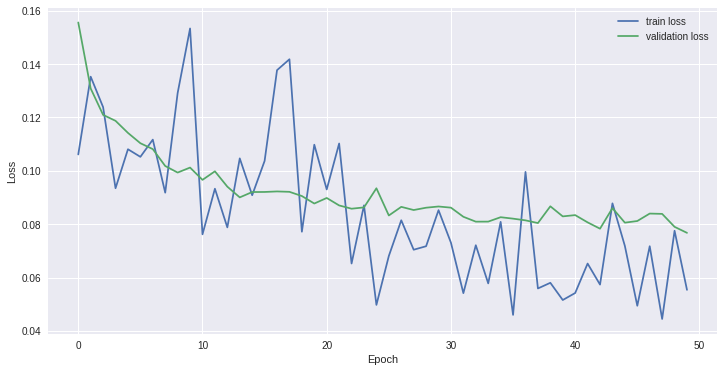

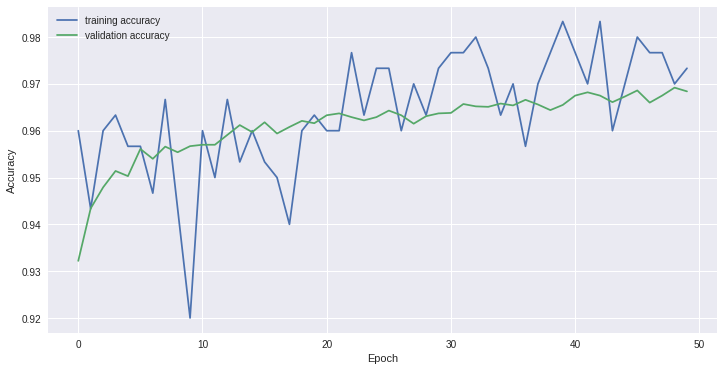

In [12]:
batch_size = 300
n_epochs = 50

ep_training_loss = []
ep_training_acc = []
ep_validation_acc = []
ep_validation_loss = []
train_size = len(x_train)
test_size = len(x_test)

# Validation data
v1 = np.random.random(test_size).argsort()
v2 = np.random.random(test_size).argsort()
vx1 = x_test_scaled[v1]
vx2 = x_test_scaled[v2]
vy1 = y_test[v1]
vy2 = y_test[v2]
v_is_same = vy1 == vy2

for epoch_idx in range(n_epochs):
    p1 = np.random.random(train_size).argsort()
    p2 = np.random.random(train_size).argsort()

    for i in range(train_size // batch_size):
        lb = i * batch_size
        
        cx1 = x_train_scaled[p1[lb:lb+batch_size]]
        cx2 = x_train_scaled[p2[lb:lb+batch_size]]
        
        cy1 = y_train[p1[lb:lb+batch_size]]
        cy2 = y_train[p2[lb:lb+batch_size]]
        
        is_same = cy1 == cy2
        closs, cacc = dist_model.train_on_batch([cx1, cx2], is_same)
    
    ep_training_loss.append(closs)
    ep_training_acc.append(cacc)
    
    vloss, vacc = dist_model.evaluate(x=[vx1, vx2], y=v_is_same, verbose=0)
    ep_validation_loss.append(vloss)
    ep_validation_acc.append(vacc)
        
    print(f'Epoch {epoch_idx} Done. Train Loss {closs:0.3f}, Train Acc. {cacc:0.3f}, Validation Loss {vloss:0.3f}, Valdation Acc. {vacc:0.3f}')
    

fig = plt.figure('Evaluation')
ax = fig.add_subplot(111)
ax.plot(ep_training_loss, label='train loss')
ax.plot(ep_validation_loss, label='validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.legend(loc='best')
plt.show()
    
fig = plt.figure('Evaluation')
ax = fig.add_subplot(111)
ax.plot(ep_training_acc, label='training accuracy')
ax.plot(ep_validation_acc, label='validation accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

Like above in the `PCA + KNN` model we can look at the new features from the embedding model projected onto the principal components. Again, in an ideal world we hope to see some solid separation of our labels.

Text(0, 0.5, 'Data Project onto PC 2')

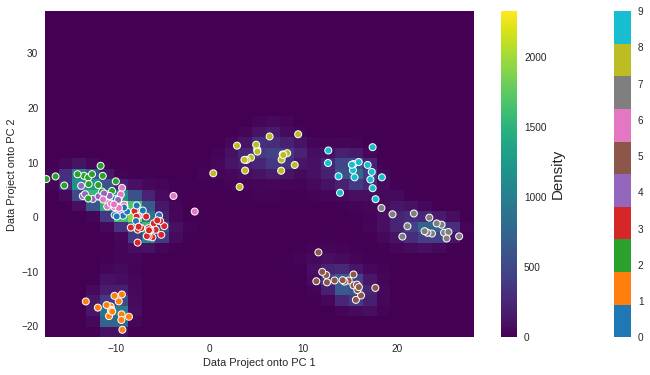

In [13]:
embeddings = embedding_net.predict(x_train_scaled)
embedding_pca = PCA()
embedding_pcs = embedding_pca.fit_transform(embeddings)

pc_x = 0
pc_y = 1

fig, ax = plt.subplots()
density_map = ax.hist2d(
    embedding_pcs[:, pc_x],
    embedding_pcs[:, pc_y],
    bins=31,
    cmap="viridis"
)
every_n = 400  # take every nth image and label to plot over the sensity map
scat = ax.scatter(
    embedding_pcs[::every_n, pc_x],
    embedding_pcs[::every_n, pc_y],
    c=y_train[::every_n],
    cmap="tab10",
    edgecolor="w",
    linewidths=1
)
plt.colorbar(scat).ax.set_label("Category")
plt.colorbar(density_map[3]).set_label("Density", fontsize=15)
ax.set_xlabel(f'Data Project onto PC {pc_x + 1}')
ax.set_ylabel(f'Data Project onto PC {pc_y + 1}')

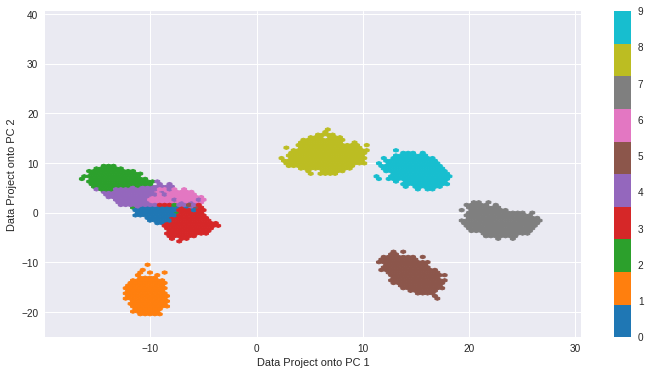

In [14]:
min_count = 10

fig = plt.figure('Principal components from images')
ax = fig.add_subplot(111)
hexb = ax.hexbin(
    embedding_pcs[:, pc_x], 
    embedding_pcs[:, pc_y], 
    mincnt=min_count, 
    C=y_train, 
    cmap='tab10',
    reduce_C_function=np.median
)
ax.set_xlabel(f'Data Project onto PC {pc_x + 1}')
ax.set_ylabel(f'Data Project onto PC {pc_y + 1}')
plt.colorbar(hexb)

In [15]:
def embedding_knn_model(embedding_net, x_train, y_train, x_test, y_test, n_neighbors=5, do_pca=False):
  
  x_train_ = embedding_net.predict(x_train)
  x_test_ = embedding_net.predict(x_test)
  
  pca = None
  if do_pca:
    pca = PCA(n_components=n_components)
    x_train_ = pca.fit_transform(x_train_)
    x_test_ = pca.transform(x_test_)
  
  
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(x_train_, y_train)

  preds = knn.predict(x_test_)
  
  acc = accuracy_score(y_test, preds)
  
  print(f'Accuracy: {acc}')
  
  return pca, knn

emb_pca, emb_knn = embedding_knn_model(embedding_net, x_train_scaled, Y_train, x_test_scaled, Y_test)

Accuracy: 0.9223


It looks like the embedding network improved our feature, and actually gave us better accuracy with the KNN than the 'simple' model did. While this is still not necessarily the best result it is still a powerful method, and from the plots above, and gives us a great way to create meaningful features.

# The Takeaway

We were able to use an embedding network to extract meaningful features from the Fashion MNIST images. We then used those features to improve the KNN's performance vs. using features from PCA on the raw images.

In addition to the model accuracy increase. The embedding's can provide other value as they are meaninful lower dimensional representations of the images. These can be easily used to find similar images. If this was a business, many parts of the business could consume these results or use the features in their models. I think these 'feature extractors' can provide a lot of value to a data science team, enabling them to pass around models or just better features to quickly improve models in other parts of the business.